## VAE
Soft contrastive estimation sets up a classification problem for optimizing the variational distribution to approximate the posterior. Often, it is also useful to train model parameters too, for example by maximum a posteriori (MAP). The classification problem does not allow for training the model parameters. Hence, we must train the model parameters in some other manner. One option, would be to add a ``-jnp.mean(joint_log_prob)`` term onto the loss function. Here, we take an alternate approach of alternating between a softcvi update and a MAP update. 

In [1]:
import equinox as eqx
import jax.numpy as jnp
import numpyro.distributions as dist
from flowjax.distributions import Normal
from jax.nn import sigmoid, softplus
from jaxtyping import Array
from numpyro.examples.datasets import MNIST, load_dataset
from softcvi.models import AbstractGuide, AbstractReparameterizedModel
from softcvi import losses
from flowjax import wrappers
import matplotlib.pyplot as plt
import jax.numpy as jnp

import jax.random as jr
import optax
from flowjax.train.train_utils import step
from flowjax.experimental.numpyro import sample
from tqdm import trange
import matplotlib.pyplot as plt
from jax.nn import relu
from typing import Callable
from flowjax.distributions import AbstractDistribution
import equinox as eqx
import jax.random as jr
import jax.numpy as jnp

from softcvi_validation import utils
import os

import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import norm
import jax


os.chdir(utils.get_abspath_project_root())


class Encoder(eqx.Module):
    layers: tuple
    z_dim: int

    def __init__(self, key, z_dim: int):
        keys = jr.split(key, 4)
        self.layers = (
            lambda x: x.reshape(28*28),
            eqx.nn.Linear(28*28, 500, key=keys[1]),
            relu,
            eqx.nn.Linear(500, 250, key=keys[2]),
            relu,
            eqx.nn.Linear(250, z_dim*2, key=keys[3]),
        )
        self.z_dim = z_dim

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Decoder(eqx.Module):
    z_dim: int
    layers: tuple

    def __init__(self, key, z_dim: int):
        keys = jr.split(key, 4)
        self.layers = (
            eqx.nn.Linear(z_dim, 250, key=keys[0]),
            relu,
            eqx.nn.Linear(250, 500, key=keys[1]),
            relu,
            eqx.nn.Linear(500, 28*28, key=keys[2]),
            lambda x: x.reshape(1, 28, 28),
            sigmoid,
        )
        self.z_dim = z_dim

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
class VAEModel(AbstractReparameterizedModel):
    decoder: Callable
    prior_dist: AbstractDistribution
    reparameterized: bool | None
    observed_names = frozenset({"x"})
    reparam_names = frozenset(set())
    
    def __init__(self, decoder: Callable):
        self.decoder = decoder
        self.prior_dist = Normal(jnp.zeros(self.decoder.z_dim))
        self.reparameterized = False

    def call_without_reparam(self, obs: dict | None = None):
        z = sample("z", self.prior_dist)
        img_loc = self.decoder(z)
        return sample("x", dist.Bernoulli(img_loc), obs=obs)


class VAEGuide(AbstractGuide):
    encoder: Callable

    def __init__(self, encoder: Callable):
        self.encoder = encoder

    def __call__(self, obs):
        z_loc, z_scales = jnp.split(self.encoder(obs["x"]), 2)
        z_scales = softplus(z_scales)
        return sample("z", Normal(z_loc, z_scales))


In [2]:
z_dim = 2
steps=100000  # Reasonable results can be seen in e.g. 10K iterations

key, subkey = jr.split(jr.PRNGKey(0))

encoder = Encoder(
    key=subkey,
    z_dim=z_dim,
)

key, subkey = jr.split(jr.PRNGKey(0))
decoder = Decoder(subkey, z_dim=2)


model =  VAEModel(decoder)
guide = VAEGuide(encoder=encoder)

train_init, train_fetch = load_dataset(
    MNIST, batch_size=None, split="train",
)
obs = train_fetch()[0]

def fit(key, model, guide, loss_fn, obs):
        
    params, static = eqx.partition(
        (model, guide),
        eqx.is_inexact_array,
        is_leaf=lambda leaf: isinstance(leaf, wrappers.NonTrainable),
    )

    optimizer = optax.adam(2e-4)
    opt_state = optimizer.init(params)

    loss_vals = []
    for _ in trange(steps):
        key, loss_key, obs_key = jr.split(key, 3)
        params, opt_state, loss_val = step(
            params,
            static,
            {"x": jr.choice(obs_key, obs, (1,))},
            loss_key,
            optimizer=optimizer,
            opt_state=opt_state,
            loss_fn=loss_fn,
            )
        loss_vals.append(loss_val)

    return eqx.combine(params, (model, guide)), loss_vals

In [3]:

loss_choices = {
   "ELBO": losses.EvidenceLowerBoundLoss(n_particles=2),
    "SoftCVI": losses.SoftContrastiveEstimationLoss(
        n_particles=2,
        alpha=0.75,
        negative_distribution="proposal",
        elbo_optimize_model=True,
        ),
}

results = {}
for label, loss_fn in loss_choices.items():
    results[label] = fit(key, model, guide, loss_fn, obs)

100%|██████████| 100000/100000 [22:14<00:00, 74.92it/s]


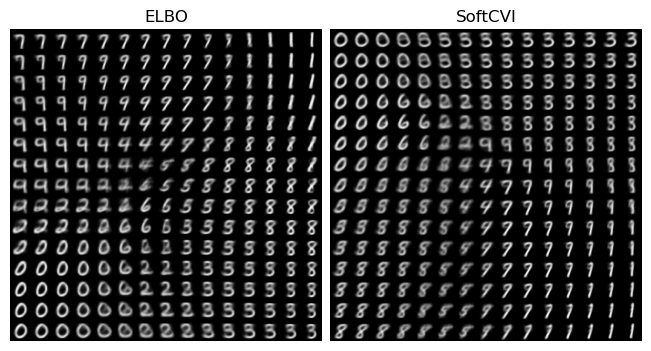

In [4]:
# Set the number of plots
plot_num = 15  # plot_num * plot_num

fig = plt.figure(
    figsize=(plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][0]/1.8),
    layout="constrained",
)

axes = fig.subplots(ncols=2)

for (label, result), ax in zip(results.items(), axes, strict=True):

    z = norm.ppf(jnp.linspace(0.1, 0.9, plot_num))
    z1, z2 = jnp.meshgrid(z, z)

    z_grid = jnp.stack([z1.ravel(), z2.ravel()], axis=-1)
    z_grid = jax.vmap(result[0][0].prior_dist.bijection.transform)(z_grid)

    # Initialize a list to store each row of images
    image_rows = []

    for row in range(plot_num):
        row_images = []
        for col in range(plot_num):
            z = z_grid[row * plot_num + col]
            img = result[0][0].decoder(z).reshape(28, 28)
            row_images.append(img)
        image_rows.append(jnp.concatenate(row_images, axis=1))
    final_image = jnp.concatenate(image_rows, axis=0)

    ax.imshow(final_image, cmap="gray")
    ax.axis('off')

    ax.set_title(label)

fig.savefig("plots/plots/mnist_latent_grid.pdf")
